In [12]:
import numpy as np
import pandas as pd
import re
from collections import Counter
from scipy.sparse import csr_matrix
from scipy import sparse
# set,defaultdict,Counter

In [13]:
def better_tokenize(sentence):
    re1=r'\b[a-zA-z]{2,}\b'
    nltk_stopwords = {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than'} 
#     pattern=re.compile("%s|%s"%(re1,re2))
    pattern=re.compile(re1)
    
    token_list=pattern.findall(sentence)
    new_list=[]
    for i in range(len(token_list)):
        if token_list[i].lower() not in nltk_stopwords:
            new_list.append(token_list[i].lower())
    return new_list

In [14]:
def to_token(path):
    email_count=0
    corpus={}    # {word: index in dictionary}
    token_list=[]

    df=pd.read_csv(path)
    for email in df['email_text']:
        email_count+=1
        token_list+=better_tokenize(email)

    # counter counts the occurance of all words
    counter=Counter(token_list)

    idx=0
    words_set=set()
    for k,v in counter.items():
        if v>=10:
            corpus[k]=idx
            words_set.add(k)
            idx+=1

    # Build the csr sparse matrix
    row,col,val = [],[],[]
    for idx, email in df.iterrows():
        tokens = better_tokenize(email['email_text'])
        # Get count of each word in sentence
        ct_dict=Counter(tokens)  

        for word, ct in ct_dict.items():
            if word in words_set:
                i = corpus[word]        
                row.append(idx)
                col.append(i)
                val.append(ct)
    BoW=(csr_matrix((val, (row, col)),shape = (len(df),len(corpus)))).toarray()
    
    BoW=np.append(BoW,np.ones((email_count,1)),axis=1) # add a bias term
    BoW=csr_matrix(BoW)
    
    
    print(BoW.shape)
    return BoW,corpus,words_set

def get_Y_train(path):
    #Y_train:(data_num,1)
    df=pd.read_csv(path)
    dim=len(df)
    Y_train=np.zeros((dim,1))
    idx=0
    for party in df['party_affiliation']:
        if party=='Democratic Party':
            Y_train[idx][0]=1
        else:
            Y_train[idx][0]=0
        idx+=1
    return Y_train



In [15]:
def _func(X,w):
    m=X.dot(w)
#     print("w.shape",w.shape)
#     print("X .shape",X.shape)
#     print("m.shape:",m.shape)
    return sigmoid(m) # y=sigmoid(wx+b)

# from scipy.sparse.linalg import expm
def sigmoid(X):
#     print("X.shape:",X.shape)
    return 1/(1+np.exp(-X))


def log_likelihood(X,Y,_beta):
    #x:[email,word]
    #y:[email,1]
    #_beta:[word,1]
    tmp=X.dot(_beta)
    res=0
#     print(tmp.shape)
#     print(Y.shape)
    for i in range(Y.shape[0]):
        res+=Y[i]*tmp[i]-np.log(1+np.exp(tmp[i]))
    return res

In [16]:
X_train,corpus,words_set=to_token('train.csv')
    
#     print(X_train)
#     X_train=np.append(X_train,np.ones((mesg_num,1)),axis=1) # add a bias term
# print("X_train:",X_train)
Y_train=get_Y_train('train.csv')
#     print("Y_train:",Y_train)


(59999, 12071)


In [17]:
import random


def logistic_regression(X_train,Y_train,learning_rate,num_steps):
    data_dim=X_train.shape[1]
    num_list=random.sample(range(Y_train.shape[0]),num_steps)
    w=np.zeros(data_dim)     #w:[word_size,1]
    log_likelihoods=[]
    for step in range(num_steps):
#         print("step=",step)
        tmp=0
        Y=Y_train[num_list[step]]
        X=X_train[num_list[step]]
        y_pred=_func(X,w) 
        
        #gradient descent
        pred_err=Y-y_pred   
#         print("prediction_error:",pred_err)
        w_grad=-X.T*pred_err
        w=w-learning_rate*w_grad

        
        if step%100==0:
            tmp=log_likelihood(X_train,Y_train,w)
            print("log likelihood=",tmp)
            log_likelihoods.append(tmp)
    return w,log_likelihoods


 # only one epoch   
def train1(X_train,Y_train,learning_rate,num_steps):
    mesg_num=Y_train[0]
    data_dim=Y_train.shape[1]
    
    w,loglikelihoods=logistic_regression(X_train,Y_train,learning_rate,num_steps)

#     Y_train_pred=np.round(_func(X_train,w)).astype(np.int)
    
    return w,loglikelihoods


In [150]:
w,loglikelihoods=train1(X_train,Y_train,5e-5,1000)



log likelihood= [-41338.78116295]
log likelihood= [-32008.56102479]
log likelihood= [-30912.87553211]
log likelihood= [-29997.73491494]
log likelihood= [-29826.36227939]
log likelihood= [-29546.56853772]
log likelihood= [-29389.00908321]
log likelihood= [-29201.07786085]
log likelihood= [-29077.15813711]
log likelihood= [-29295.6460424]


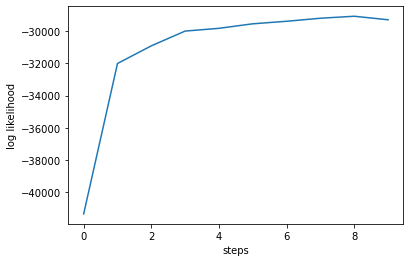

In [158]:

import matplotlib.pyplot as plt
plt.plot(loglikelihoods)
plt.ylabel('log likelihood')
plt.xlabel('steps')
# fig.show()
plt.savefig('imgs/part2_loglikelihood1000.jpg')

In [182]:
w,loglikelihoods=train1(X_train,Y_train,5e-5,59999)

log likelihood= [-41423.65004332]
log likelihood= [-32099.72758695]
log likelihood= [-30435.82635388]
log likelihood= [-29920.70093006]
log likelihood= [-29742.99467966]
log likelihood= [-29533.39453423]
log likelihood= [-29398.05085806]
log likelihood= [-29275.70238374]
log likelihood= [-28979.12285523]
log likelihood= [-28959.30047792]
log likelihood= [-28724.77928391]
log likelihood= [-28566.91097234]
log likelihood= [-28369.87432587]
log likelihood= [-28368.94027541]
log likelihood= [-28368.41583591]
log likelihood= [-27924.87928084]
log likelihood= [-27720.87857079]
log likelihood= [-27773.35738236]
log likelihood= [-27660.07383001]
log likelihood= [-27379.49935154]
log likelihood= [-27280.84114936]
log likelihood= [-27162.57319786]
log likelihood= [-27295.72390295]
log likelihood= [-27034.64991563]
log likelihood= [-26857.72555469]
log likelihood= [-26737.61899063]
log likelihood= [-26639.13872762]
log likelihood= [-26520.84770177]
log likelihood= [-26498.03873318]
log likelihood

log likelihood= [-18125.72261392]
log likelihood= [-18105.38596766]
log likelihood= [-18069.99860044]
log likelihood= [-18079.23782262]
log likelihood= [-18035.33341594]
log likelihood= [-18096.19581762]
log likelihood= [-18067.87946111]
log likelihood= [-18028.10021532]
log likelihood= [-17991.95146871]
log likelihood= [-17971.32508217]
log likelihood= [-17943.87136264]
log likelihood= [-17938.91801428]
log likelihood= [-17906.96231939]
log likelihood= [-17913.37645971]
log likelihood= [-17866.6978014]
log likelihood= [-17905.23417465]
log likelihood= [-17893.10762586]
log likelihood= [-17832.37060091]
log likelihood= [-17812.94812217]
log likelihood= [-17836.85588426]
log likelihood= [-17801.49595067]
log likelihood= [-17828.01168512]
log likelihood= [-17771.9470611]
log likelihood= [-17736.31087615]
log likelihood= [-17722.15833207]
log likelihood= [-17717.38593641]
log likelihood= [-17725.55808163]
log likelihood= [-17661.20575104]
log likelihood= [-17641.09978137]
log likelihood= 

log likelihood= [-15170.57353053]
log likelihood= [-15189.51496176]
log likelihood= [-15165.09002279]
log likelihood= [-15193.60155724]
log likelihood= [-15196.72241791]
log likelihood= [-15199.97205466]
log likelihood= [-15137.06032094]
log likelihood= [-15167.81376488]
log likelihood= [-15135.31105989]
log likelihood= [-15110.34460822]
log likelihood= [-15146.01116535]
log likelihood= [-15120.84582215]
log likelihood= [-15071.69592082]
log likelihood= [-15056.21319758]
log likelihood= [-15049.58948251]
log likelihood= [-15036.87673925]
log likelihood= [-15036.82627341]
log likelihood= [-15145.83282834]
log likelihood= [-15036.83567955]
log likelihood= [-15012.13833009]
log likelihood= [-15016.82734922]
log likelihood= [-14996.26240085]
log likelihood= [-14984.91196025]
log likelihood= [-15085.1085388]
log likelihood= [-15135.20659115]
log likelihood= [-15082.02487635]
log likelihood= [-14967.39295604]
log likelihood= [-14982.09332843]
log likelihood= [-14952.09986603]
log likelihood=

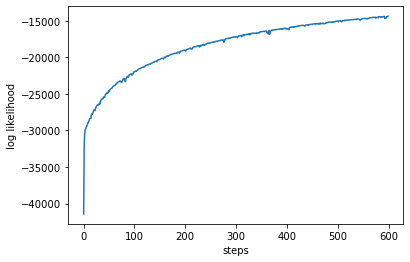

In [183]:
import matplotlib.pyplot as plt
plt.plot(loglikelihoods)
plt.ylabel('log likelihood')
plt.xlabel('steps')
# fig.show()
plt.savefig('imgs/part2_loglikelihood59999.jpg')

In [18]:
def logistic_regression_multi(X_train,Y_train,learning_rate,num_steps,num_epoch):
    data_dim=X_train.shape[1]
    n=Y_train.shape[0]
    samples=random.sample(range(n),min(num_steps*num_epoch,n))
    w=np.zeros(data_dim)     #w:[word_size,1]
    log_likelihoods=[]
    
    for epoch in range(num_epoch):
        print("epoch=",epoch)
        for step in range(epoch*num_steps,min(epoch*num_steps+num_steps,n)):
    #         print("step=",step)
            tmp=0
            Y=Y_train[samples[step%n]]
            X=X_train[samples[step%n]]
            y_pred=_func(X,w) 

            #gradient descent
            pred_err=Y-y_pred   
    #         print("prediction_error:",pred_err)
            w_grad=-X.T*pred_err
            w=w-learning_rate*w_grad


            
            if step%100==0:
                tmp=log_likelihood(X_train,Y_train,w)
                print("log likelihood=",tmp)
                log_likelihoods.append(tmp)
    return w,log_likelihoods

 # only many epochs 
def train_multi(X_train,Y_train,learning_rate,num_steps,num_epochs):
    mesg_num=Y_train[0]
    data_dim=Y_train.shape[1]
    
    w,loglikelihoods=logistic_regression_multi(X_train,Y_train,learning_rate,num_steps,num_epochs)

#     Y_train_pred=np.round(_func(X_train,w)).astype(np.int)
    
    return w,loglikelihoods

In [192]:
w,log_likelihoods=train_multi(X_train,Y_train,1e-5,1000,55)

epoch= 0
log likelihood= [-41547.17168614]
log likelihood= [-38133.8434893]
log likelihood= [-36382.6360965]
log likelihood= [-34862.68659568]
log likelihood= [-33207.39523868]
log likelihood= [-32136.56090214]
log likelihood= [-32007.50589702]
log likelihood= [-31652.11137105]
log likelihood= [-31227.42178775]
log likelihood= [-30751.84953796]
epoch= 1
log likelihood= [-30596.8607517]
log likelihood= [-30342.85787974]
log likelihood= [-30274.42967744]
log likelihood= [-30090.64486622]
log likelihood= [-29961.80875279]
log likelihood= [-29880.16240604]
log likelihood= [-29783.75146876]
log likelihood= [-29726.7102554]
log likelihood= [-29650.26270697]
log likelihood= [-29596.99638327]
epoch= 2
log likelihood= [-29556.96523558]
log likelihood= [-29468.6799735]
log likelihood= [-29428.6155136]
log likelihood= [-29384.44691738]
log likelihood= [-29335.41270113]
log likelihood= [-29263.66995968]
log likelihood= [-29203.16449979]
log likelihood= [-29167.78131569]
log likelihood= [-29130.424

log likelihood= [-24611.79782855]
log likelihood= [-24584.32172824]
log likelihood= [-24602.6203877]
log likelihood= [-24579.61564917]
epoch= 24
log likelihood= [-24580.21783571]
log likelihood= [-24560.90731423]
log likelihood= [-24540.08612733]
log likelihood= [-24513.27619025]
log likelihood= [-24491.41622569]
log likelihood= [-24476.67521206]
log likelihood= [-24461.01835183]
log likelihood= [-24448.12859719]
log likelihood= [-24440.52472425]
log likelihood= [-24422.82758304]
epoch= 25
log likelihood= [-24413.72001581]
log likelihood= [-24396.84510717]
log likelihood= [-24382.50350852]
log likelihood= [-24370.99536569]
log likelihood= [-24360.91746968]
log likelihood= [-24345.64140944]
log likelihood= [-24332.58078384]
log likelihood= [-24323.98576524]
log likelihood= [-24311.8892583]
log likelihood= [-24298.19330784]
epoch= 26
log likelihood= [-24287.64803784]
log likelihood= [-24275.50657869]
log likelihood= [-24269.79834258]
log likelihood= [-24257.90703067]
log likelihood= [-24

log likelihood= [-22089.96422759]
log likelihood= [-22071.25569645]
log likelihood= [-22064.12912045]
log likelihood= [-22055.10515413]
log likelihood= [-22047.85017531]
log likelihood= [-22037.28887537]
log likelihood= [-22031.16739246]
log likelihood= [-22029.27427201]
log likelihood= [-22014.50897948]
epoch= 48
log likelihood= [-22005.25844551]
log likelihood= [-21999.90597312]
log likelihood= [-21994.57373726]
log likelihood= [-21990.12426624]
log likelihood= [-21981.0683224]
log likelihood= [-21970.30649352]
log likelihood= [-21966.7320913]
log likelihood= [-21966.09704618]
log likelihood= [-21944.52393812]
log likelihood= [-21926.22800311]
epoch= 49
log likelihood= [-21914.90795099]
log likelihood= [-21909.15645616]
log likelihood= [-21901.02309749]
log likelihood= [-21893.06905374]
log likelihood= [-21888.5940984]
log likelihood= [-21877.11909499]
log likelihood= [-21880.49712765]
log likelihood= [-21869.77862381]
log likelihood= [-21868.78905066]
log likelihood= [-21851.5765594

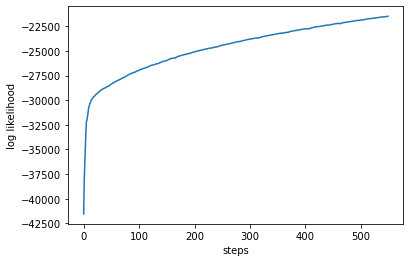

In [193]:
import matplotlib.pyplot as plt
plt.plot(log_likelihoods)
plt.ylabel('log likelihood')
plt.xlabel('steps')
# fig.show()
plt.savefig('imgs/part2_loglikelihood55000.jpg')

In [20]:
def get_X_test(path,corpus,words_set):
    
    df=pd.read_csv(path)
    row,col,val = [],[],[]
    email_count=len(df)
    for idx, email in df.iterrows():
        tokens = better_tokenize(email['email_text'])
        # Get count of each word in sentence
        ct_dict=Counter(tokens)  

        for word, ct in ct_dict.items():
            if word in words_set:
                i = corpus[word]        
                row.append(idx)
                col.append(i)
                val.append(ct)
    BoW=(csr_matrix((val, (row, col)),shape = (len(df),len(corpus)))).toarray()
    BoW=np.append(BoW,np.ones((email_count,1)),axis=1) # add a bias term
    return BoW

X_dev=get_X_test('dev.csv',corpus,words_set)
Y_dev=get_Y_train('dev.csv')

In [21]:
X_dev.shape

(20000, 12071)

In [35]:
TP=0
FP=0
FN=0

Y_dev_pred=_func(X_dev,w)

correct=0

for i in range(Y_dev.shape[0]):
#     print(Y_dev_pred[i])
    if Y_dev_pred[i]>0.5:
        Y_dev_pred[i]=1
    elif Y_dev_pred[i]<0.5:
        Y_dev_pred[i]=0
    else:
        Y_dev_pred[i]=rand()%2
    if Y_dev_pred[i]==1 and Y_dev[i]==1:
        TP+=1
    elif Y_dev_pred[i]==0 and Y_dev[i]==1:
        FN+=1
    elif Y_dev_pred[i]==1 and Y_dev[i]==0:
        FP+=1
    if Y_dev_pred[i]==1 and Y_dev[i]==1 or Y_dev_pred[i]==0 and Y_dev[i]==0:
        correct+=1

P=TP/(TP+FP)
R=TP/(TP+FN)
f1=2*P*R/(P+R)

print("F1 value is:",f1)
print("accuracy is:",correct/Y_dev.shape[0])

F1 value is: 0.9695852534562212
accuracy is: 0.9505


In [33]:
w,log_likelihoods=train_multi(X_train,Y_train,9.5e-4,1000,40)

plt.plot(log_likelihoods)
plt.ylabel('log likelihood')
plt.xlabel('steps')
# fig.show()
plt.savefig('imgs/part2_loglikelihood40000.jpg')

TP=0
FP=0
FN=0

Y_dev_pred=_func(X_dev,w)

correct=0

for i in range(Y_dev.shape[0]):
#     print(Y_dev_pred[i])
    if Y_dev_pred[i]>0.5:
        Y_dev_pred[i]=1
    elif Y_dev_pred[i]<0.5:
        Y_dev_pred[i]=0
    else:
        Y_dev_pred[i]=rand()%2
    if Y_dev_pred[i]==1 and Y_dev[i]==1:
        TP+=1
    elif Y_dev_pred[i]==0 and Y_dev[i]==1:
        FN+=1
    elif Y_dev_pred[i]==1 and Y_dev[i]==0:
        FP+=1
    if Y_dev_pred[i]==1 and Y_dev[i]==1 or Y_dev_pred[i]==0 and Y_dev[i]==0:
        correct+=1

P=TP/(TP+FP)
R=TP/(TP+FN)
f1=2*P*R/(P+R)

print("F1 value is:",f1)
print("accuracy is:",correct/Y_dev.shape[0])

epoch= 0
log likelihood= [-56814.48834543]
log likelihood= [-28973.58663391]
log likelihood= [-27951.23694491]
log likelihood= [-26001.21321844]
log likelihood= [-24949.10093253]
log likelihood= [-23612.86361577]
log likelihood= [-23628.41952712]
log likelihood= [-23842.82925626]
log likelihood= [-21744.18185008]
log likelihood= [-22268.07760299]
epoch= 1
log likelihood= [-22718.61727774]
log likelihood= [-22232.33936543]
log likelihood= [-19958.97715954]
log likelihood= [-20535.7823267]
log likelihood= [-19331.23598606]


KeyboardInterrupt: 

9.5e-4,1000,40
best on test set now

In [36]:
X_test=get_X_test('test.csv',corpus,words_set)
Y_test_pred=_func(X_test,w)
Y_pred=[]
for i in range(Y_dev.shape[0]):
#     print(Y_dev_pred[i])
    if Y_test_pred[i]>0.5:
        Y_pred.append('Democratic Party')
    elif Y_test_pred[i]<0.5:
        Y_pred.append('Republican Party')
    else:
        Y_text_pred[i]=rand()%2
        if Y_text_pred[i]==1:
            Y_pred.append('Democratic Party')
        else:
            Y_pred.append('Republican Party')


In [37]:
df_test=pd.read_csv('test.csv')
title=df_test['uid_email'].to_numpy()

d={'uid_email':title,'party_affiliation':Y_pred}
df_out=pd.DataFrame(data=d)

In [38]:
df_out.to_csv('submission1.csv',index=False)

In [34]:
w,log_likelihoods=train_multi(X_train,Y_train,9.7e-4,1000,47)

epoch= 0
log likelihood= [-37681.25229267]
log likelihood= [-29469.00076594]
log likelihood= [-26718.2614195]
log likelihood= [-27870.21099032]
log likelihood= [-27325.19382187]
log likelihood= [-23605.3150067]
log likelihood= [-23303.35107642]
log likelihood= [-21562.78100448]
log likelihood= [-21105.59600263]
log likelihood= [-22011.69925699]
epoch= 1
log likelihood= [-20401.06764279]
log likelihood= [-21175.52733815]
log likelihood= [-19515.00115348]
log likelihood= [-19912.20985344]
log likelihood= [-20677.80902369]
log likelihood= [-19888.5615593]
log likelihood= [-27977.05732874]
log likelihood= [-19311.23631091]
log likelihood= [-18632.7952129]
log likelihood= [-18948.78634266]
epoch= 2
log likelihood= [-21550.95040146]
log likelihood= [-17336.75003438]
log likelihood= [-17591.33649872]
log likelihood= [-17320.15181766]
log likelihood= [-17330.91834945]
log likelihood= [-16599.90552485]
log likelihood= [-16688.16396478]
log likelihood= [-16410.88828875]
log likelihood= [-16258.5

log likelihood= [-9205.51200635]
log likelihood= [-9296.07471613]
log likelihood= [-9618.40777251]
epoch= 24
log likelihood= [-9180.30504711]
log likelihood= [-9678.9530651]
log likelihood= [-9599.29864891]
log likelihood= [-9170.59675048]
log likelihood= [-9132.71114243]
log likelihood= [-9417.25989109]
log likelihood= [-11327.88671415]
log likelihood= [-9498.22929653]
log likelihood= [-9549.43603346]
log likelihood= [-9165.96934811]
epoch= 25
log likelihood= [-9144.14959338]
log likelihood= [-9107.53300204]
log likelihood= [-9068.53900281]
log likelihood= [-9790.68911846]
log likelihood= [-9451.50536004]
log likelihood= [-9075.97250725]
log likelihood= [-9547.6393958]
log likelihood= [-9385.64343485]
log likelihood= [-9305.96585443]
log likelihood= [-9239.00623032]
epoch= 26
log likelihood= [-10138.80831108]
log likelihood= [-9455.4448031]
log likelihood= [-9103.86665329]
log likelihood= [-9279.00606198]
log likelihood= [-9012.40279744]
log likelihood= [-9096.1254873]
log likelihood=

Best now: train_multi(X_train,Y_train,9.45e-4,1000,40)